1. Ride Demand Prediction (Regression or Time-Series Forecasting)

Loading Modules : 

In [104]:
import pandas as pd
import glob             # For getting a list of files in a directory
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

Loading Dataset : 

In [105]:
# CSV - 2014
files_2014 = glob.glob("../Dataset/Topic_1n2/*14.csv")
# to concatenate all the files
df_2014 = pd.concat([pd.read_csv(f, encoding="latin1") for f in files_2014]) # used latin1 encoding as utf-8 didn't work which is by default

# CSV - 2015
files_2015 = pd.read_csv("../Dataset/Topic_1n2/uber-raw-data-janjune-15.csv", encoding="latin1")
df_2015 = pd.DataFrame(files_2015)

In [106]:
df_2014.head(5)

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [107]:
df_2015.head(5)

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [108]:
# As 2014 data gives exact lat/lon coordinates, Will predict using 2014 data
df_2014.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4534327 entries, 0 to 1028135
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 173.0+ MB


Data pre-processing

In [109]:
df_2014.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

In [110]:
print(df_2014.duplicated().sum())

82581


In [111]:
df_2014.drop_duplicates()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
1028131,9/30/2014 22:57:00,40.7668,-73.9845,B02764
1028132,9/30/2014 22:57:00,40.6911,-74.1773,B02764
1028133,9/30/2014 22:58:00,40.8519,-73.9319,B02764
1028134,9/30/2014 22:58:00,40.7081,-74.0066,B02764


Feature Engineering

In [112]:
# Converting the 'Date/Time' column to datetime format
df_2014['Date/Time'] = pd.to_datetime(df_2014['Date/Time'], format = '%m/%d/%Y %H:%M:%S')

As per the data, we can split ['Date/Time'] column into : Hour, WeekDays<br>
(Not considering month (as limited months))

In [113]:
df_2014['WeekDay'] = df_2014['Date/Time'].dt.weekday
df_2014['Hour'] = df_2014['Date/Time'].dt.hour

In [114]:
# Rounding the latitude and longitude to 2 decimal places, as can't predict exact precised location
df_2014['Lat'] = df_2014['Lat'].round(2)
df_2014['Lon'] = df_2014['Lon'].round(2)

In [115]:
df_2014.drop(columns = ['Date/Time'], inplace = True)

In [116]:
df_2014.head(5)

,Lat,Lon,Base,WeekDay,Hour
0,40.77,-73.95,B02512,1,0
1,40.73,-74.03,B02512,1,0
2,40.73,-73.99,B02512,1,0
3,40.76,-73.98,B02512,1,0
4,40.76,-73.97,B02512,1,0


EDA :<br>
In EDA, let's progress with exploration by visualizing & analyzing the following common relations in graphs : <br>
* Trip count by Day of the week<br>
* Trip count by Hourly basis<br>
* Trip count by Weekday & Hour<br>
* Trip count by Location(Lat & Lon)<br>


1. Trip count by Day of the week

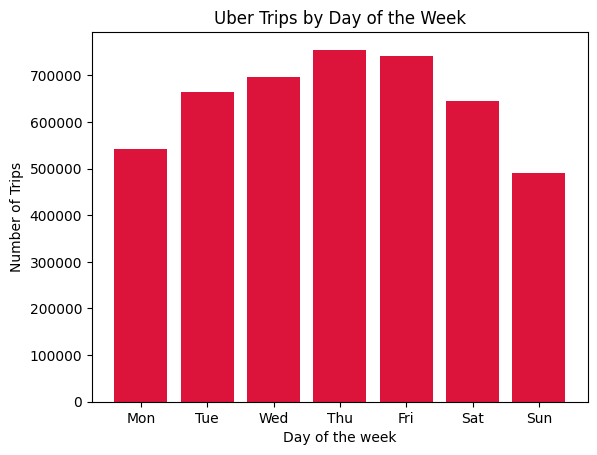

In [117]:
# Bar plot :
plt.title('Uber Trips by Day of the Week')
plt.xlabel('Day of the week')
plt.ylabel('Number of Trips') 
x = df_2014['WeekDay'].value_counts().sort_index()
plt.bar(x.index, x.values, color = 'crimson')
plt.xticks(ticks = x.index, labels= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

Conclusion : 
* Trip demand surges form Monday & increases steadily & peaks at Thursdays & Fridays achieving its lowest on Sundays, here it is considerable that people are more active by the end of the weekdays which might be because of business or social reasons.
* Trips are minimum on Sundays & it is logically considerable as people may like to take a rest on that day.
* Hence, must allocate more drivers towards end of the week for optimized operational efficiency.

2. Trip count by Hour 

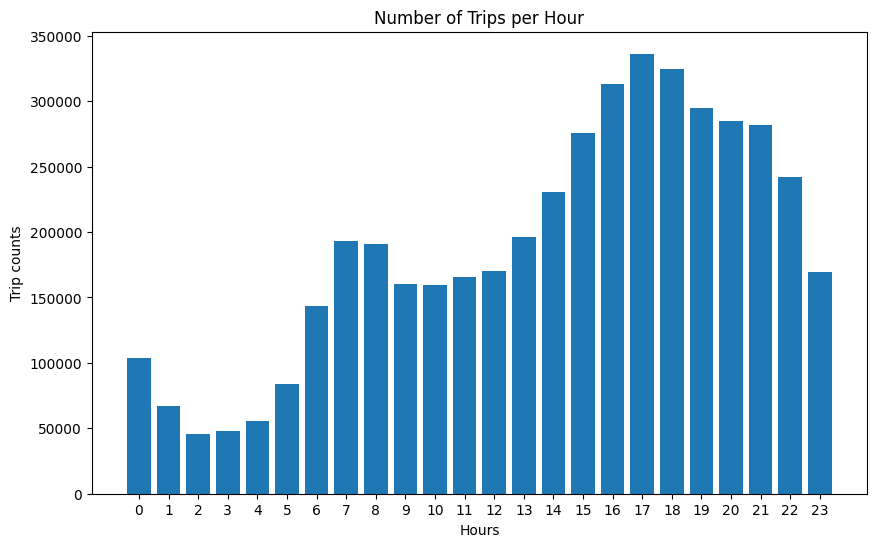

In [118]:
plt.figure(figsize=(10,6))
plt.title('Number of Trips per Hour')
plt.xlabel('Hours')
plt.ylabel('Trip counts')
y = df_2014['Hour'].value_counts().sort_index()
plt.bar(y.index, y.values)
plt.xticks(ticks=range(24))
plt.show()

Conclusions : 
* During the Early Hours from midnight till 5AM, we can see the least trip demand.
* We can see Peak Demand Window from 4PM to 7PM. This alligns with the office end hours, which states Majority of the Clients are office workers.

3. Trips by WeekDay & Hour

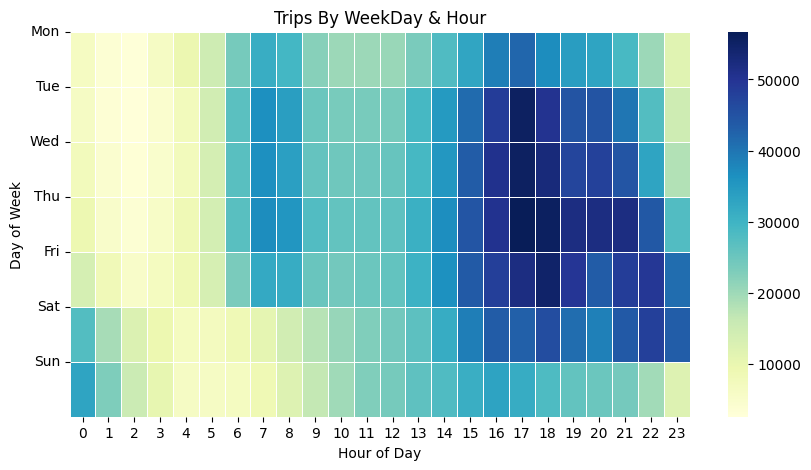

In [119]:
plt.figure(figsize=(10, 5))
plt.title('Trips By WeekDay & Hour')
sns.heatmap(df_2014.groupby(['WeekDay', 'Hour']).size().unstack(), cmap='YlGnBu', linewidth=0.5)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()

Conclusions :
* As predicted in trip_demand vs hour graph & weekday, here we cay clearly see trip_demand is higher from 4PM to 7PM & from Mon to Fri. So, this conifrms that our clients are office workers.
* Sunday seems less busy.

## Storytelling Analysis: Uber Ride Demand by Weekday and Hour

Imagine the city as a living, breathing entity—its pulse quickens and slows as people move about their daily routines. This heatmap is a window into that rhythm, revealing how Uber rides ebb and flow across the week and throughout each day.

As the week begins, the city wakes up slowly. Mondays and Tuesdays show a gentle start, with ride demand gradually building as people return to work and settle into their routines. The mornings see a modest uptick, likely from commuters heading to offices, but the real action begins as the day progresses.

By midweek—Wednesday, Thursday, and especially Friday—the city is buzzing. The heatmap glows brightest in the late afternoon and early evening, between 4 PM and 7 PM. This is when offices empty, social plans ignite, and the demand for rides surges. These peaks tell us that people are not just working hard but also making the most of their evenings, whether it's meeting friends, running errands, or heading out for dinner.

Saturdays paint a different picture. The demand is more evenly spread, with steady activity from late morning through the evening. The city is alive with leisure—shopping, brunches, and outings. There’s no sharp rush hour, just a consistent hum of movement as people enjoy their weekend.

Sundays, however, are unique. The early hours—just after midnight—see a final burst of activity, likely from late Saturday night revelers heading home. But as the day unfolds, the city slows down. Demand drops, reflecting a collective pause as people rest, recharge, and prepare for the week ahead.

Across all days, the quietest hours are in the deep of night, from 2 AM to 5 AM, when the city sleeps and the streets are calm.

For Uber, these patterns are more than just numbers—they are a guide to the city’s heartbeat. By understanding when and where demand peaks, Uber can ensure drivers are ready to meet riders at just the right moments, making the city’s rhythm smoother for everyone.